# 01 | Explore CARAVAN Dataset

## Purpose
Build familiarity with the CARAVAN dataset before training. This notebook covers:
1. Directory structure and file organization
2. How basins are identified and organized by region
3. Attribute file contents — what metadata is available per basin
4. Timeseries file contents — what forcing and streamflow variables are available
5. A deep-dive into a Salt Lake City / Utah area basin — hydrograph, precipitation,
   solar radiation, snow fraction, and basin boundary visualization

Working through this notebook will give you the intuition needed to understand
the config choices made in `02_neural_hydrology_caravan_setup.ipynb`.

---

> **Note for new users:** Paths containing `Meyer` should be updated to your own
> project directory. The shared CARAVAN data at `johnsonrc-group1` is available
> to all members of the group and does not need to change.

**Key paths:**
- CARAVAN data: `/uufs/chpc.utah.edu/common/home/johnsonrc-group1/CARAVAN/CARAVAN_data`
- Project directory: `/uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point

# ── Paths ──────────────────────────────────────────────────────────────────────
PROJECT_DIR      = Path("/uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project")
CARAVAN_DATA_DIR = Path("/uufs/chpc.utah.edu/common/home/johnsonrc-group1/CARAVAN/CARAVAN_data")

# ── Verify ─────────────────────────────────────────────────────────────────────
assert PROJECT_DIR.exists(),      f"Project directory not found: {PROJECT_DIR}"
assert CARAVAN_DATA_DIR.exists(), f"CARAVAN data not found: {CARAVAN_DATA_DIR}"

# ── Plot style ─────────────────────────────────────────────────────────────────
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi'   : 150,
    'font.size'    : 11,
    'axes.titlesize': 12,
    'axes.labelsize': 11,
})

print("✓ Paths configured")
print(f"  Project    : {PROJECT_DIR}")
print(f"  CARAVAN    : {CARAVAN_DATA_DIR}")

✓ Paths configured
  Project    : /uufs/chpc.utah.edu/common/home/civil-group1/Meyer/neuralhydrology_project
  CARAVAN    : /uufs/chpc.utah.edu/common/home/johnsonrc-group1/CARAVAN/CARAVAN_data


## 1. CARAVAN Directory Structure

CARAVAN is organized into three top-level subdirectories under `CARAVAN_data/`:
```
CARAVAN/
└── CARAVAN_data/
    ├── README.md
    ├── VERSION
    ├── index.html
    ├── caravan-long-logo.png
    ├── licenses/
    │
    ├── attributes/                  ← static basin characteristics (one folder per region)
    │   ├── camels/
    │   │   ├── attributes_caravan_camels.csv       ← ERA5-Land climate indices (includes frac_snow)
    │   │   ├── attributes_hydroatlas_camels.csv    ← geomorphology, soil, land cover
    │   │   └── attributes_other_camels.csv         ← gauge metadata, country, area
    │   ├── camelsaus/
    │   ├── camelsbr/
    │   ├── camelscl/
    │   ├── camelsgb/
    │   ├── hysets/
    │   └── lamah/
    │
    ├── timeseries/
    │   ├── csv/                     ← daily forcing + streamflow (one CSV per basin, all 7 regions)
    │   │   ├── camels/
    │   │   ├── camelsaus/
    │   │   ├── camelsbr/
    │   │   ├── camelscl/
    │   │   ├── camelsgb/
    │   │   ├── hysets/
    │   │   └── lamah/
    │   └── netcdf/                  ← NetCDF format (only available for 4 of 7 regions)
    │       ├── camels/
    │       ├── camelscl/
    │       ├── hysets/
    │       └── lamah/
    │
    └── shapefiles/                  ← basin boundary polygons (all 7 regions)
        ├── camels/
        ├── camelsaus/
        ├── camelsbr/
        ├── camelscl/
        ├── camelsgb/
        ├── hysets/
        └── lamah/

### Basin ID format
Every basin has a unique ID of the form `{region}_{gageID}`, for example:
- `camels_01013500` — USGS gauge 01013500 from the CAMELS-US region
- `hysets_10BE022` — a Canadian basin from the HYSETS region
- `lamah_399` — a European basin from the LamaH region

This prefix-based naming is how neuralhydrology knows which subdirectory to look in
when loading timeseries and attributes for a given basin.

In [2]:
# ── Top-level structure ────────────────────────────────────────────────────────
print("CARAVAN Dataset Structure:")
print("=" * 60)

for top_item in sorted(CARAVAN_DATA_DIR.iterdir()):
    if top_item.is_dir():
        n_subdirs = len([x for x in top_item.iterdir() if x.is_dir()])
        print(f"\n📁 {top_item.name}/  ({n_subdirs} regions)")
        for region_dir in sorted(top_item.iterdir()):
            if region_dir.is_dir():
                # count files inside
                files = list(region_dir.iterdir())
                # for timeseries, count basin CSVs
                csvs = list(region_dir.glob("*.csv"))
                if csvs:
                    print(f"   📁 {region_dir.name}/  ({len(csvs):,} basin CSV files)")
                else:
                    print(f"   📁 {region_dir.name}/  ({len(files)} files)")
                    for f in sorted(files):
                        print(f"      📄 {f.name}")
    else:
        size_kb = top_item.stat().st_size / 1024
        print(f"\n📄 {top_item.name}  ({size_kb:.1f} KB)")

# ── Total basin count ──────────────────────────────────────────────────────────
print("\n" + "=" * 60)
timeseries_dir = CARAVAN_DATA_DIR / 'timeseries' / 'csv'
total_basins = sum(
    len(list(region_dir.glob("*.csv")))
    for region_dir in timeseries_dir.iterdir()
    if region_dir.is_dir()
)
print(f"Total basins across all regions: {total_basins:,}")

CARAVAN Dataset Structure:

📄 README.md  (11.5 KB)

📄 VERSION  (0.0 KB)

📁 attributes/  (7 regions)
   📁 camels/  (3 basin CSV files)
   📁 camelsaus/  (3 basin CSV files)
   📁 camelsbr/  (3 basin CSV files)
   📁 camelscl/  (3 basin CSV files)
   📁 camelsgb/  (3 basin CSV files)
   📁 hysets/  (3 basin CSV files)
   📁 lamah/  (3 basin CSV files)

📄 caravan-long-logo.png  (1568.4 KB)

📄 index.html  (1.0 KB)

📁 licenses/  (7 regions)
   📁 camels/  (1 files)
      📄 license_camels.md
   📁 camelsaus/  (1 files)
      📄 license_camelsaus.md
   📁 camelsbr/  (1 files)
      📄 license_camelsbr.md
   📁 camelscl/  (1 files)
      📄 license_camelscl.md
   📁 camelsgb/  (1 files)
      📄 license_camelsgb.md
   📁 hysets/  (1 files)
      📄 license_hysets.md
   📁 lamah/  (1 files)
      📄 license_lamah.md

📁 shapefiles/  (7 regions)
   📁 camels/  (5 files)
      📄 camels_basin_shapes.cpg
      📄 camels_basin_shapes.dbf
      📄 camels_basin_shapes.prj
      📄 camels_basin_shapes.shp
      📄 camels_basin

## 2. Basin Attributes

Each region has up to three attribute CSV files, each covering a different category
of basin metadata. Every row is one basin (indexed by basin ID) and every column
is one attribute.

### The three attribute file types

| File | Contents |
|---|---|
| `attributes_caravan_{region}.csv` | ERA5-Land derived climate indices — mean annual temperature, precipitation, aridity, `frac_snow`, seasonality, etc. |
| `attributes_hydroatlas_{region}.csv` | HydroATLAS geomorphology — elevation, slope, drainage area, soil type, land cover fractions, lithology |
| `attributes_other_{region}.csv` | Gauge metadata — gauge name, country, latitude, longitude, drainage area from gauge records |

### Key attributes for our work

| Attribute | File | Why it matters |
|---|---|---|
| `frac_snow` | caravan | Our primary filter for snow-dominated basin selection |
| `p_mean` | caravan | Mean annual precipitation (mm/day) |
| `t_mean` | caravan | Mean annual temperature (°C) |
| `aridity` | caravan | PET / P ratio — controls catchment water balance regime |
| `gauge_lat` / `gauge_lon` | other | Gauge location for mapping |
| `area` | other | Drainage area (km²) |
| `ele_mt_sav` | hydroatlas | Mean catchment elevation (m) |

### Important notes
- Not all attributes are available for every region — some columns will be `NaN`
  for regions where the underlying data source didn't cover that area
- The `attributes_other` file is the best source for gauge coordinates,
  which we will use in the mapping section of this notebook

In [3]:
REGIONS = ['camels', 'camelsaus', 'camelsbr', 'camelscl', 'camelsgb', 'hysets', 'lamah']
attributes_dir = CARAVAN_DATA_DIR / 'attributes'

print("CARAVAN Attribute File Summary:")
print("=" * 60)

for region in REGIONS:
    region_dir = attributes_dir / region
    print(f"\n{region.upper()}")
    
    for attr_file in sorted(region_dir.glob("*.csv")):
        df = pd.read_csv(attr_file, index_col=0)
        print(f"  📄 {attr_file.name}")
        print(f"     {len(df):,} basins  ×  {len(df.columns)} attributes")
        
        # Show a few representative column names
        col_preview = df.columns[:5].tolist()
        if len(df.columns) > 5:
            col_preview.append('...')
        print(f"     Columns: {col_preview}")

# ── Snow attribute summary across all regions ──────────────────────────────────
print("\n" + "=" * 60)
print("frac_snow summary by region:")
print("=" * 60)

for region in REGIONS:
    attr_file = attributes_dir / region / f"attributes_caravan_{region}.csv"
    df = pd.read_csv(attr_file, index_col=0)
    
    if 'frac_snow' in df.columns:
        snow = df['frac_snow'].dropna()
        n_snow = (snow > 0.3).sum()
        print(f"\n  {region.upper():12s}  ({len(df):,} basins)")
        print(f"    frac_snow range : {snow.min():.3f} – {snow.max():.3f}")
        print(f"    mean            : {snow.mean():.3f}")
        print(f"    > 0.30 (snow)   : {n_snow:,} basins ({n_snow/len(df)*100:.1f}%)")
    else:
        print(f"\n  {region.upper():12s}  — frac_snow not available")

CARAVAN Attribute File Summary:

CAMELS
  📄 attributes_caravan_camels.csv
     671 basins  ×  14 attributes
     Columns: ['aridity_ERA5_LAND', 'aridity_FAO_PM', 'frac_snow', 'high_prec_dur', 'high_prec_freq', '...']
  📄 attributes_hydroatlas_camels.csv
     671 basins  ×  196 attributes
     Columns: ['sgr_dk_sav', 'glc_pc_s06', 'glc_pc_s07', 'nli_ix_sav', 'glc_pc_s04', '...']
  📄 attributes_other_camels.csv
     671 basins  ×  5 attributes
     Columns: ['gauge_name', 'country', 'gauge_lat', 'gauge_lon', 'area']

CAMELSAUS
  📄 attributes_caravan_camelsaus.csv
     561 basins  ×  14 attributes
     Columns: ['aridity_ERA5_LAND', 'aridity_FAO_PM', 'frac_snow', 'high_prec_dur', 'high_prec_freq', '...']
  📄 attributes_hydroatlas_camelsaus.csv
     561 basins  ×  196 attributes
     Columns: ['aet_mm_s01', 'aet_mm_s02', 'aet_mm_s03', 'aet_mm_s04', 'aet_mm_s05', '...']
  📄 attributes_other_camelsaus.csv
     561 basins  ×  5 attributes
     Columns: ['area', 'country', 'gauge_lat', 'gauge_

## 3. Timeseries Files

Each basin has a single CSV file containing daily time steps from 1981–2020.
Rows are days, columns are variables. The file is named by basin ID, for example:
`camels_01013500.csv`.

### Column structure

Every timeseries file contains the following column groups:

| Group | Variables | Source |
|---|---|---|
| **Date** | `date` (YYYY-MM-DD) | Index column |
| **Streamflow** | `streamflow` | Observed gauge records (mm/day, area-normalized) |
| **Temperature** | `temperature_2m_mean`, `temperature_2m_min`, `temperature_2m_max` | ERA5-Land |
| **Precipitation** | `total_precipitation_sum` | ERA5-Land |
| **Radiation** | `surface_net_solar_radiation_mean`, `surface_net_thermal_radiation_mean` | ERA5-Land |
| **Wind** | `u_component_of_wind_10m_mean`, `v_component_of_wind_10m_mean` | ERA5-Land |
| **Humidity** | `dewpoint_temperature_2m_mean` | ERA5-Land |
| **Snow** | `snow_depth_water_equivalent_mean`, `snowfall_sum`, `snow_cover` (some regions) | ERA5-Land / MODIS |
| **ET** | `potential_evaporation_sum` | ERA5-Land |

### A note on streamflow units
Streamflow in CARAVAN is reported in **mm/day** — discharge normalized by drainage area.
This makes basins of different sizes directly comparable and is the standard unit
expected by neuralhydrology's loss functions.

### Missing data
Streamflow records have gaps (coded as `NaN`) where gauge records are unavailable.
ERA5-Land forcing is spatially complete and has no gaps — it is a reanalysis product,
not observational, so every grid cell has a value for every day.

### What we pass to the model
Of the full variable set, we will use four dynamic inputs for training:
`total_precipitation_sum`, `temperature_2m_max`, `temperature_2m_min`,
and `surface_net_solar_radiation_mean`. These four capture the dominant
physical controls on snow accumulation and melt in mountainous catchments,
and represent data that is reasonably available in real-time.

In [4]:
# ── Load a sample CAMELS basin timeseries ─────────────────────────────────────
timeseries_dir = CARAVAN_DATA_DIR / 'timeseries' / 'csv'

sample_file = next((timeseries_dir / 'camels').glob('*.csv'))
df_sample = pd.read_csv(sample_file, parse_dates=['date'])

print(f"Sample file : {sample_file.name}")
print(f"Shape       : {df_sample.shape}  ({df_sample.shape[0]:,} days × {df_sample.shape[1]} columns)")
print(f"Date range  : {df_sample['date'].min().date()}  →  {df_sample['date'].max().date()}")

# ── Full column list ───────────────────────────────────────────────────────────
print(f"\nAll columns ({len(df_sample.columns)}):")
print("-" * 40)
for col in df_sample.columns:
    dtype  = str(df_sample[col].dtype)
    n_null = df_sample[col].isna().sum()
    null_str = f"  ({n_null:,} NaN)" if n_null > 0 else ""
    print(f"  {col:<45s} {dtype}{null_str}")

# ── Quick stats on key variables ───────────────────────────────────────────────
key_vars = [
    'streamflow',
    'total_precipitation_sum',
    'temperature_2m_max',
    'temperature_2m_min',
    'surface_net_solar_radiation_mean',
    'snow_depth_water_equivalent_mean',
]

print(f"\nDescriptive statistics — key variables:")
print("-" * 40)
available = [v for v in key_vars if v in df_sample.columns]
print(df_sample[available].describe().round(3).to_string())

Sample file : camels_05495500.csv
Shape       : (26662, 41)  (26,662 days × 41 columns)
Date range  : 1951-01-01  →  2023-12-30

All columns (41):
----------------------------------------
  date                                          datetime64[ns]
  dewpoint_temperature_2m_max                   float64
  dewpoint_temperature_2m_mean                  float64
  dewpoint_temperature_2m_min                   float64
  potential_evaporation_sum_ERA5_LAND           float64
  potential_evaporation_sum_FAO_PENMAN_MONTEITH float64
  snow_depth_water_equivalent_max               float64
  snow_depth_water_equivalent_mean              float64
  snow_depth_water_equivalent_min               float64
  streamflow                                    float64  (14,275 NaN)
  surface_net_solar_radiation_max               float64
  surface_net_solar_radiation_mean              float64
  surface_net_solar_radiation_min               float64
  surface_net_thermal_radiation_max             float64
  surfa

## 4. Deep Dive — A Utah / Salt Lake City Area Basin

To make the dataset concrete, we will identify a CAMELS-US basin in the Salt Lake City
/ Wasatch Front area and explore its full record in detail.

### How we find it
The `attributes_other_camels.csv` file contains gauge latitude and longitude for every
CAMELS-US basin. We will:
1. Load gauge coordinates for all CAMELS-US basins
2. Compute the distance from each gauge to Salt Lake City (40.76°N, 111.89°W)
3. Select the closest basin and verify it makes physical sense

### What we will look at
Once we have the basin, we will explore:

| Plot | Variables | Purpose |
|---|---|---|
| Basin boundary map | Shapefile polygon + gauge point | Spatial context |
| Hydrograph | `streamflow` | Seasonal runoff pattern |
| Precipitation | `total_precipitation_sum` | Forcing input |
| Temperature | `temperature_2m_max`, `temperature_2m_min` | Snow/melt driver |
| Solar radiation | `surface_net_solar_radiation_mean` | Energy balance input |
| Snow | `snow_depth_water_equivalent_mean`, `snowfall_sum` | Snow accumulation signal |
| Wind | `u_component_of_wind_10m_mean`, `v_component_of_wind_10m_mean` | Supplementary forcing |

### Why this matters
Visualizing a local basin gives intuition for what the LSTM is learning —
the lag between peak SWE and peak streamflow, the temperature sensitivity
of melt timing, and the role of radiation in driving the energy balance.
These are exactly the signals we want the model to transfer to Alaska.

In [5]:
# ── Load CAMELS-US gauge metadata ──────────────────────────────────────────────
other_attrs = pd.read_csv(
    attributes_dir / 'camels' / 'attributes_other_camels.csv',
    index_col=0
)
caravan_attrs = pd.read_csv(
    attributes_dir / 'camels' / 'attributes_caravan_camels.csv',
    index_col=0
)
hydroatlas_attrs = pd.read_csv(
    attributes_dir / 'camels' / 'attributes_hydroatlas_camels.csv',
    index_col=0
)

# ── Salt Lake City coordinates ─────────────────────────────────────────────────
SLC_LAT =  40.76
SLC_LON = -111.89

# ── Compute distance to SLC for every gauge ────────────────────────────────────
other_attrs['dist_to_slc'] = np.sqrt(
    (other_attrs['gauge_lat'] - SLC_LAT) ** 2 +
    (other_attrs['gauge_lon'] - SLC_LON) ** 2
)

# ── Find closest basin ─────────────────────────────────────────────────────────
closest       = other_attrs.sort_values('dist_to_slc').iloc[0]
UTAH_BASIN_ID = closest.name

basin_caravan    = caravan_attrs.loc[UTAH_BASIN_ID]
basin_hydroatlas = hydroatlas_attrs.loc[UTAH_BASIN_ID]

# ── Area correction from USGS record ──────────────────────────────────────────
# attributes_other reports 2531.6 km² which is incorrect for this gauge.
# USGS NWIS confirms drainage area = 26.8 mi² = ~69 km²
# https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=10166430
BASIN_AREA_KM2 = 26.8 * 2.58999  # mi² → km²

print(f"Closest CAMELS-US basin to Salt Lake City:")
print(f"  Basin ID   : {UTAH_BASIN_ID}")
print(f"  Gauge name : {closest['gauge_name']}")
print(f"  Latitude   : {closest['gauge_lat']:.4f}°N")
print(f"  Longitude  : {closest['gauge_lon']:.4f}°W")
print(f"  Area       : {BASIN_AREA_KM2:.1f} km²  (USGS verified — attributes_other value is incorrect)")
print(f"  Distance   : {closest['dist_to_slc']:.3f}° from SLC")

print(f"\nKey basin attributes:")
print(f"  frac_snow  : {basin_caravan['frac_snow']:.3f}  (threshold > 0.30 = snow-dominated)")
print(f"  p_mean     : {basin_caravan['p_mean']:.3f} mm/day")
print(f"  aridity    : {basin_caravan['aridity_ERA5_LAND']:.3f}  (PET/P — >1 = water limited)")
print(f"  elev_mean  : {basin_hydroatlas['ele_mt_sav']:.0f} m")
print(f"  temp_mean  : {basin_hydroatlas['tmp_dc_syr'] / 10:.1f} °C")

print(f"\n⚠ Note: The 'area' column in attributes_other_camels.csv reported {closest['area']:.1f} km²")
print(f"  for this basin, which is incorrect. Always verify drainage area against")
print(f"  the original gauge record before using it in calculations.")
print(f"\nNote: frac_snow = {basin_caravan['frac_snow']:.3f} is just below our 0.30 training")
print(f"threshold — this basin is representative of the Wasatch Front but would")
print(f"not be included in our snow-dominated training set.")

Closest CAMELS-US basin to Salt Lake City:
  Basin ID   : camels_10166430
  Gauge name : WEST CANYON CREEK NEAR CEDAR FORT, UT
  Latitude   : 40.4052°N
  Longitude  : -112.1005°W
  Area       : 69.4 km²  (USGS verified — attributes_other value is incorrect)
  Distance   : 0.413° from SLC

Key basin attributes:
  frac_snow  : 0.254  (threshold > 0.30 = snow-dominated)
  p_mean     : 1.439 mm/day
  aridity    : 3.320  (PET/P — >1 = water limited)
  elev_mean  : 1641 m
  temp_mean  : 9.2 °C

⚠ Note: The 'area' column in attributes_other_camels.csv reported 2531.6 km²
  for this basin, which is incorrect. Always verify drainage area against
  the original gauge record before using it in calculations.

Note: frac_snow = 0.254 is just below our 0.30 training
threshold — this basin is representative of the Wasatch Front but would
not be included in our snow-dominated training set.


## 5. Basin Boundary Visualization

CARAVAN includes basin boundary shapefiles for each region under `shapefiles/`.
We will plot:
1. The basin boundary polygon for West Canyon Creek
2. The gauge location
3. Salt Lake City for geographic reference
4. Surrounding CAMELS-US basins in Utah for regional context

### Shapefile location
```
CARAVAN_data/
└── shapefiles/
    └── camels/
        └── camels_basin_boundaries.shp    ← all CAMELS-US basins in one file
```

The shapefile contains one polygon per basin, with the basin ID as the join key.
We will use `geopandas` to load, filter, and plot the boundaries.

### What to look for
- **Basin shape** — West Canyon Creek drains the western slope of the Oquirrh Mountains,
  so we expect an elongated polygon oriented roughly north-south along the range
- **Gauge location** — should sit at the basin outlet (downstream end of the polygon)
- **Neighboring basins** — surrounding CAMELS-US basins give context for how densely
  the dataset samples the Wasatch Front / Great Basin region

## A Note on CARAVAN Basin Boundaries

The basin boundaries in CARAVAN may look unfamiliar if you are used to working with
USGS HUC (Hydrologic Unit Code) boundaries. They are derived from a completely different
source and method:

| Property | CARAVAN (HydroSHEDS) | USGS HUC |
|---|---|---|
| **Source DEM** | SRTM 90m global DEM | Various, manually refined |
| **Delineation** | Automated flow routing | Manual hydrographer refinement |
| **Coverage** | Global | United States only |
| **Accuracy** | Good in mountainous terrain, poor in flat/endorheic basins | Very high |
| **Purpose** | Attribute aggregation for ML datasets | Official watershed management |

### Why do some boundaries look wrong?
Automated flow routing algorithms struggle in two situations:
- **Flat terrain** — small DEM errors dominate flow direction in low-relief areas
- **Endorheic (closed) basins** — like the Great Basin, where water does not drain
  to the ocean. The algorithm may incorrectly route flow into the lake bed.

The West Canyon Creek basin shown here is a good example — the polygon correctly
captures the Oquirrh Mountain drainage area but includes an erroneous extension
over the Great Salt Lake, which is a HydroSHEDS artifact in the endorheic Great Basin.

### Does this affect the model?
No — the basin boundaries are used only for:
1. Spatial aggregation of static attributes (elevation, land cover, soil type)
2. Visualization

The actual training data is the **observed gauge timeseries** paired with **ERA5-Land
grid cell forcings** spatially averaged within the boundary. The flat lake artifact
contributes essentially no precipitation or temperature signal that would differ
meaningfully from the surrounding land surface, so model training is unaffected.

### For reference
If you need clean basin boundaries for your own analysis, the official USGS HUC
boundaries are available via the National Hydrography Dataset (NHD) and the
USGS National Map.

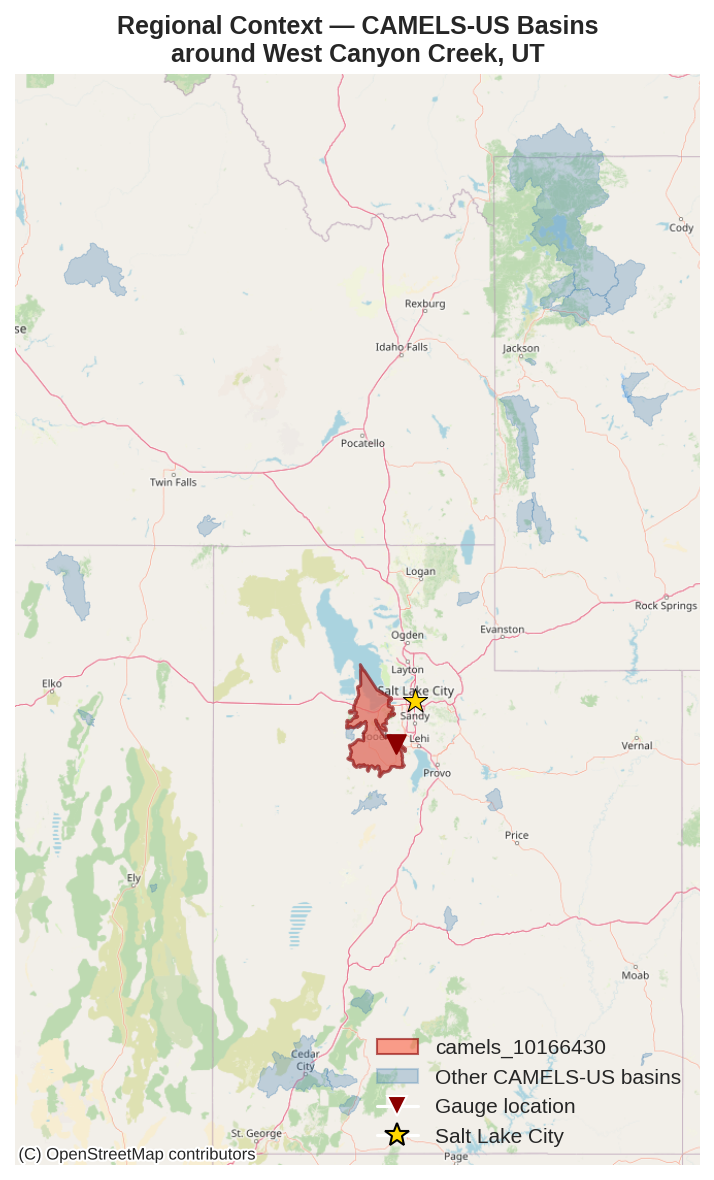

✓ Saved: results/utah_basin_regional.png


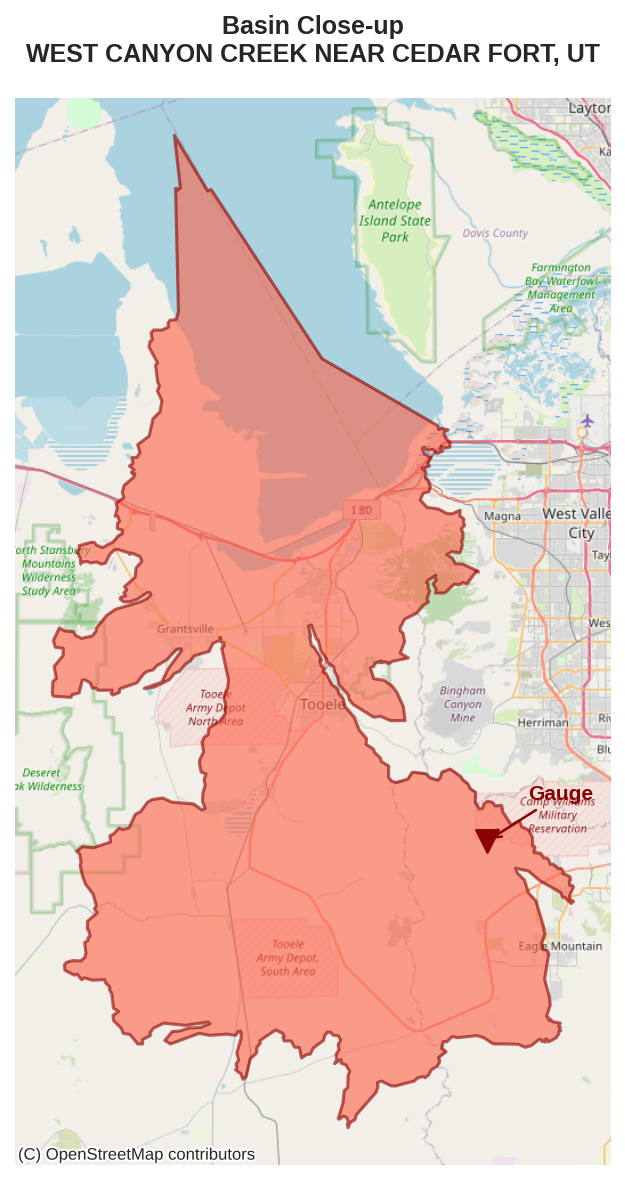

✓ Saved: results/utah_basin_closeup.png


In [6]:
import contextily as ctx

# ── Load shapefile ─────────────────────────────────────────────────────────────
shapefile_path = CARAVAN_DATA_DIR / 'shapefiles' / 'camels' / 'camels_basin_shapes.shp'
gdf = gpd.read_file(shapefile_path)

# ── Extract our Utah basin and nearby basins ───────────────────────────────────
utah_basin      = gdf[gdf['gauge_id'] == UTAH_BASIN_ID]
bounds          = utah_basin.total_bounds
regional_basins = gdf.cx[
    bounds[0] - 3.0 : bounds[2] + 3.0,
    bounds[1] - 3.0 : bounds[3] + 3.0
]

# ── Points ─────────────────────────────────────────────────────────────────────
gauge_point = gpd.GeoDataFrame(
    geometry=[Point(closest['gauge_lon'], closest['gauge_lat'])], crs='epsg:4326')
slc_point = gpd.GeoDataFrame(
    geometry=[Point(SLC_LON, SLC_LAT)], crs='epsg:4326')

# ── Reproject ──────────────────────────────────────────────────────────────────
utah_basin_wm   = utah_basin.to_crs(epsg=3857)
regional_wm     = regional_basins.to_crs(epsg=3857)
gauge_point_wm  = gauge_point.to_crs(epsg=3857)
slc_point_wm    = slc_point.to_crs(epsg=3857)

# ── Plot ───────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 8))

regional_wm.plot(ax=ax, facecolor='steelblue', edgecolor='steelblue',
                 linewidth=0.5, alpha=0.3)
utah_basin_wm.plot(ax=ax, facecolor='tomato', edgecolor='darkred',
                   linewidth=1.5, alpha=0.6, zorder=3)
gauge_point_wm.plot(ax=ax, color='darkred', marker='v', markersize=80, zorder=5)
slc_point_wm.plot(ax=ax, color='gold', marker='*', markersize=150,
                  edgecolor='black', linewidth=0.5, zorder=5)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=7)
ax.set_title('Regional Context — CAMELS-US Basins\naround West Canyon Creek, UT',
             fontweight='bold', fontsize=12)
ax.set_axis_off()

legend_elements = [
    mpatches.Patch(facecolor='tomato', edgecolor='darkred', alpha=0.6,
                   label=f'{UTAH_BASIN_ID}'),
    mpatches.Patch(facecolor='steelblue', edgecolor='steelblue', alpha=0.3,
                   label='Other CAMELS-US basins'),
    plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='darkred',
               markersize=10, label='Gauge location'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gold',
               markeredgecolor='black', markersize=12, label='Salt Lake City'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
#plt.savefig(PROJECT_DIR / 'results' / 'utah_basin_regional.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: results/utah_basin_regional.png")

# ── Reuse reprojected layers from cell above ───────────────────────────────────
bounds_wm = utah_basin_wm.total_bounds

fig, ax = plt.subplots(figsize=(8, 8))

utah_basin_wm.plot(ax=ax, facecolor='tomato', edgecolor='darkred',
                   linewidth=1.5, alpha=0.6, zorder=3)
gauge_point_wm.plot(ax=ax, color='darkred', marker='v', markersize=120, zorder=5)

pad = 5000
ax.set_xlim(bounds_wm[0] - pad, bounds_wm[2] + pad)
ax.set_ylim(bounds_wm[1] - pad, bounds_wm[3] + pad)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

ax.set_title(f'Basin Close-up\n{closest["gauge_name"]}', fontweight='bold', fontsize=12)
ax.set_axis_off()

ax.annotate('Gauge', xy=(gauge_point_wm.geometry.x[0], gauge_point_wm.geometry.y[0]),
            xytext=(20, 20), textcoords='offset points',
            fontsize=10, color='darkred', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='darkred', lw=1.2))

plt.tight_layout()
#plt.savefig(PROJECT_DIR / 'results' / 'utah_basin_closeup.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: results/utah_basin_closeup.png")

## 6. Timeseries Deep Dive — West Canyon Creek, UT

Now that we've located and mapped the basin, let's load its full daily timeseries
and visualize the key variables. This gives us intuition for what the LSTM is
learning — the seasonal patterns, lag between snow accumulation and streamflow,
and the role of temperature and radiation in driving melt.

### What we will plot
We will create a multi-panel figure with one panel per variable group:

1. **Streamflow** — the target variable; expect a spring snowmelt peak
2. **Precipitation** — total daily precipitation (rain + snow combined in ERA5-Land)
3. **Temperature** — daily min/max; the zero-degree crossing drives melt onset
4. **Solar radiation** — net solar energy at the surface; peaks in summer,
   drives the energy available for snowmelt
5. **Snow depth (SWE)** — ERA5-Land snow water equivalent; shows accumulation
   and depletion cycle
6. **Wind speed** — derived from u and v components; supplementary forcing

### Plotting approach
We will plot a single representative water year (October–September) averaged
across all available years to show the **climatological seasonal cycle** clearly,
rather than a raw timeseries which can be noisy. We will also show the full
period of record as a light background so the interannual variability is visible.

### Water year convention
A water year runs from **October 1 to September 30** and is named for the
calendar year in which it ends. For example, water year 2000 runs from
October 1, 1999 to September 30, 2000. This convention is standard in
hydrology because it keeps the snow accumulation and melt season intact
within a single year.

In [7]:
# ── Load full timeseries for our Utah basin ────────────────────────────────────
ts_file = CARAVAN_DATA_DIR / 'timeseries' / 'csv' / 'camels' / f'{UTAH_BASIN_ID}.csv'
df = pd.read_csv(ts_file, parse_dates=['date'])
df = df.set_index('date')

print(f"Basin timeseries loaded: {UTAH_BASIN_ID}")
print(f"  Date range : {df.index.min().date()} → {df.index.max().date()}")
print(f"  Shape      : {df.shape}  ({df.shape[0]:,} days × {df.shape[1]} columns)")
print(f"\nAll columns:")
for col in df.columns:
    n_null = df[col].isna().sum()
    null_str = f"  ({n_null:,} NaN)" if n_null > 0 else ""
    print(f"  {col}{null_str}")

# ── Assign water year ──────────────────────────────────────────────────────────
df['water_year'] = df.index.year.where(df.index.month < 10, df.index.year + 1)
water_year_start = pd.to_datetime((df['water_year'] - 1).astype(str) + '-10-01')
df['doy_water']  = (df.index - water_year_start).dt.days

print(f"\nWater year assignment:")
print(f"  doy_water range  : {df['doy_water'].min()} to {df['doy_water'].max()}")
print(f"  Water years      : {df['water_year'].min()} – {df['water_year'].max()}")

# ── Check streamflow data availability by water year ──────────────────────────
sf_by_year = df.groupby('water_year')['streamflow'].apply(lambda x: x.notna().sum())

print(f"\nStreamflow data availability by water year:")
print(f"{'Water Year':<12} {'Days with data':<16} {'% complete'}")
print("-" * 44)
for wy, n_days in sf_by_year.items():
    pct   = n_days / 365 * 100
    flag  = '✓' if pct > 80 else '⚠' if pct > 20 else '✗'
    print(f"  {flag} {wy:<12} {n_days:<16} {pct:.0f}%")

# ── Identify good water years ──────────────────────────────────────────────────
good_years = sf_by_year[sf_by_year > 300].index.tolist()
print(f"\n✓ Water years with >300 days of streamflow : {len(good_years)}")
print(f"  {good_years[0]} – {good_years[-1]}")
print(f"\n✓ Ready for plotting")

Basin timeseries loaded: camels_10166430
  Date range : 1951-01-01 → 2023-12-30
  Shape      : (26662, 40)  (26,662 days × 40 columns)

All columns:
  dewpoint_temperature_2m_max
  dewpoint_temperature_2m_mean
  dewpoint_temperature_2m_min
  potential_evaporation_sum_ERA5_LAND
  potential_evaporation_sum_FAO_PENMAN_MONTEITH
  snow_depth_water_equivalent_max
  snow_depth_water_equivalent_mean
  snow_depth_water_equivalent_min
  streamflow  (16,343 NaN)
  surface_net_solar_radiation_max
  surface_net_solar_radiation_mean
  surface_net_solar_radiation_min
  surface_net_thermal_radiation_max
  surface_net_thermal_radiation_mean
  surface_net_thermal_radiation_min
  surface_pressure_max
  surface_pressure_mean
  surface_pressure_min
  temperature_2m_max
  temperature_2m_mean
  temperature_2m_min
  total_precipitation_sum
  u_component_of_wind_10m_max
  u_component_of_wind_10m_mean
  u_component_of_wind_10m_min
  v_component_of_wind_10m_max
  v_component_of_wind_10m_mean
  v_component_of_win

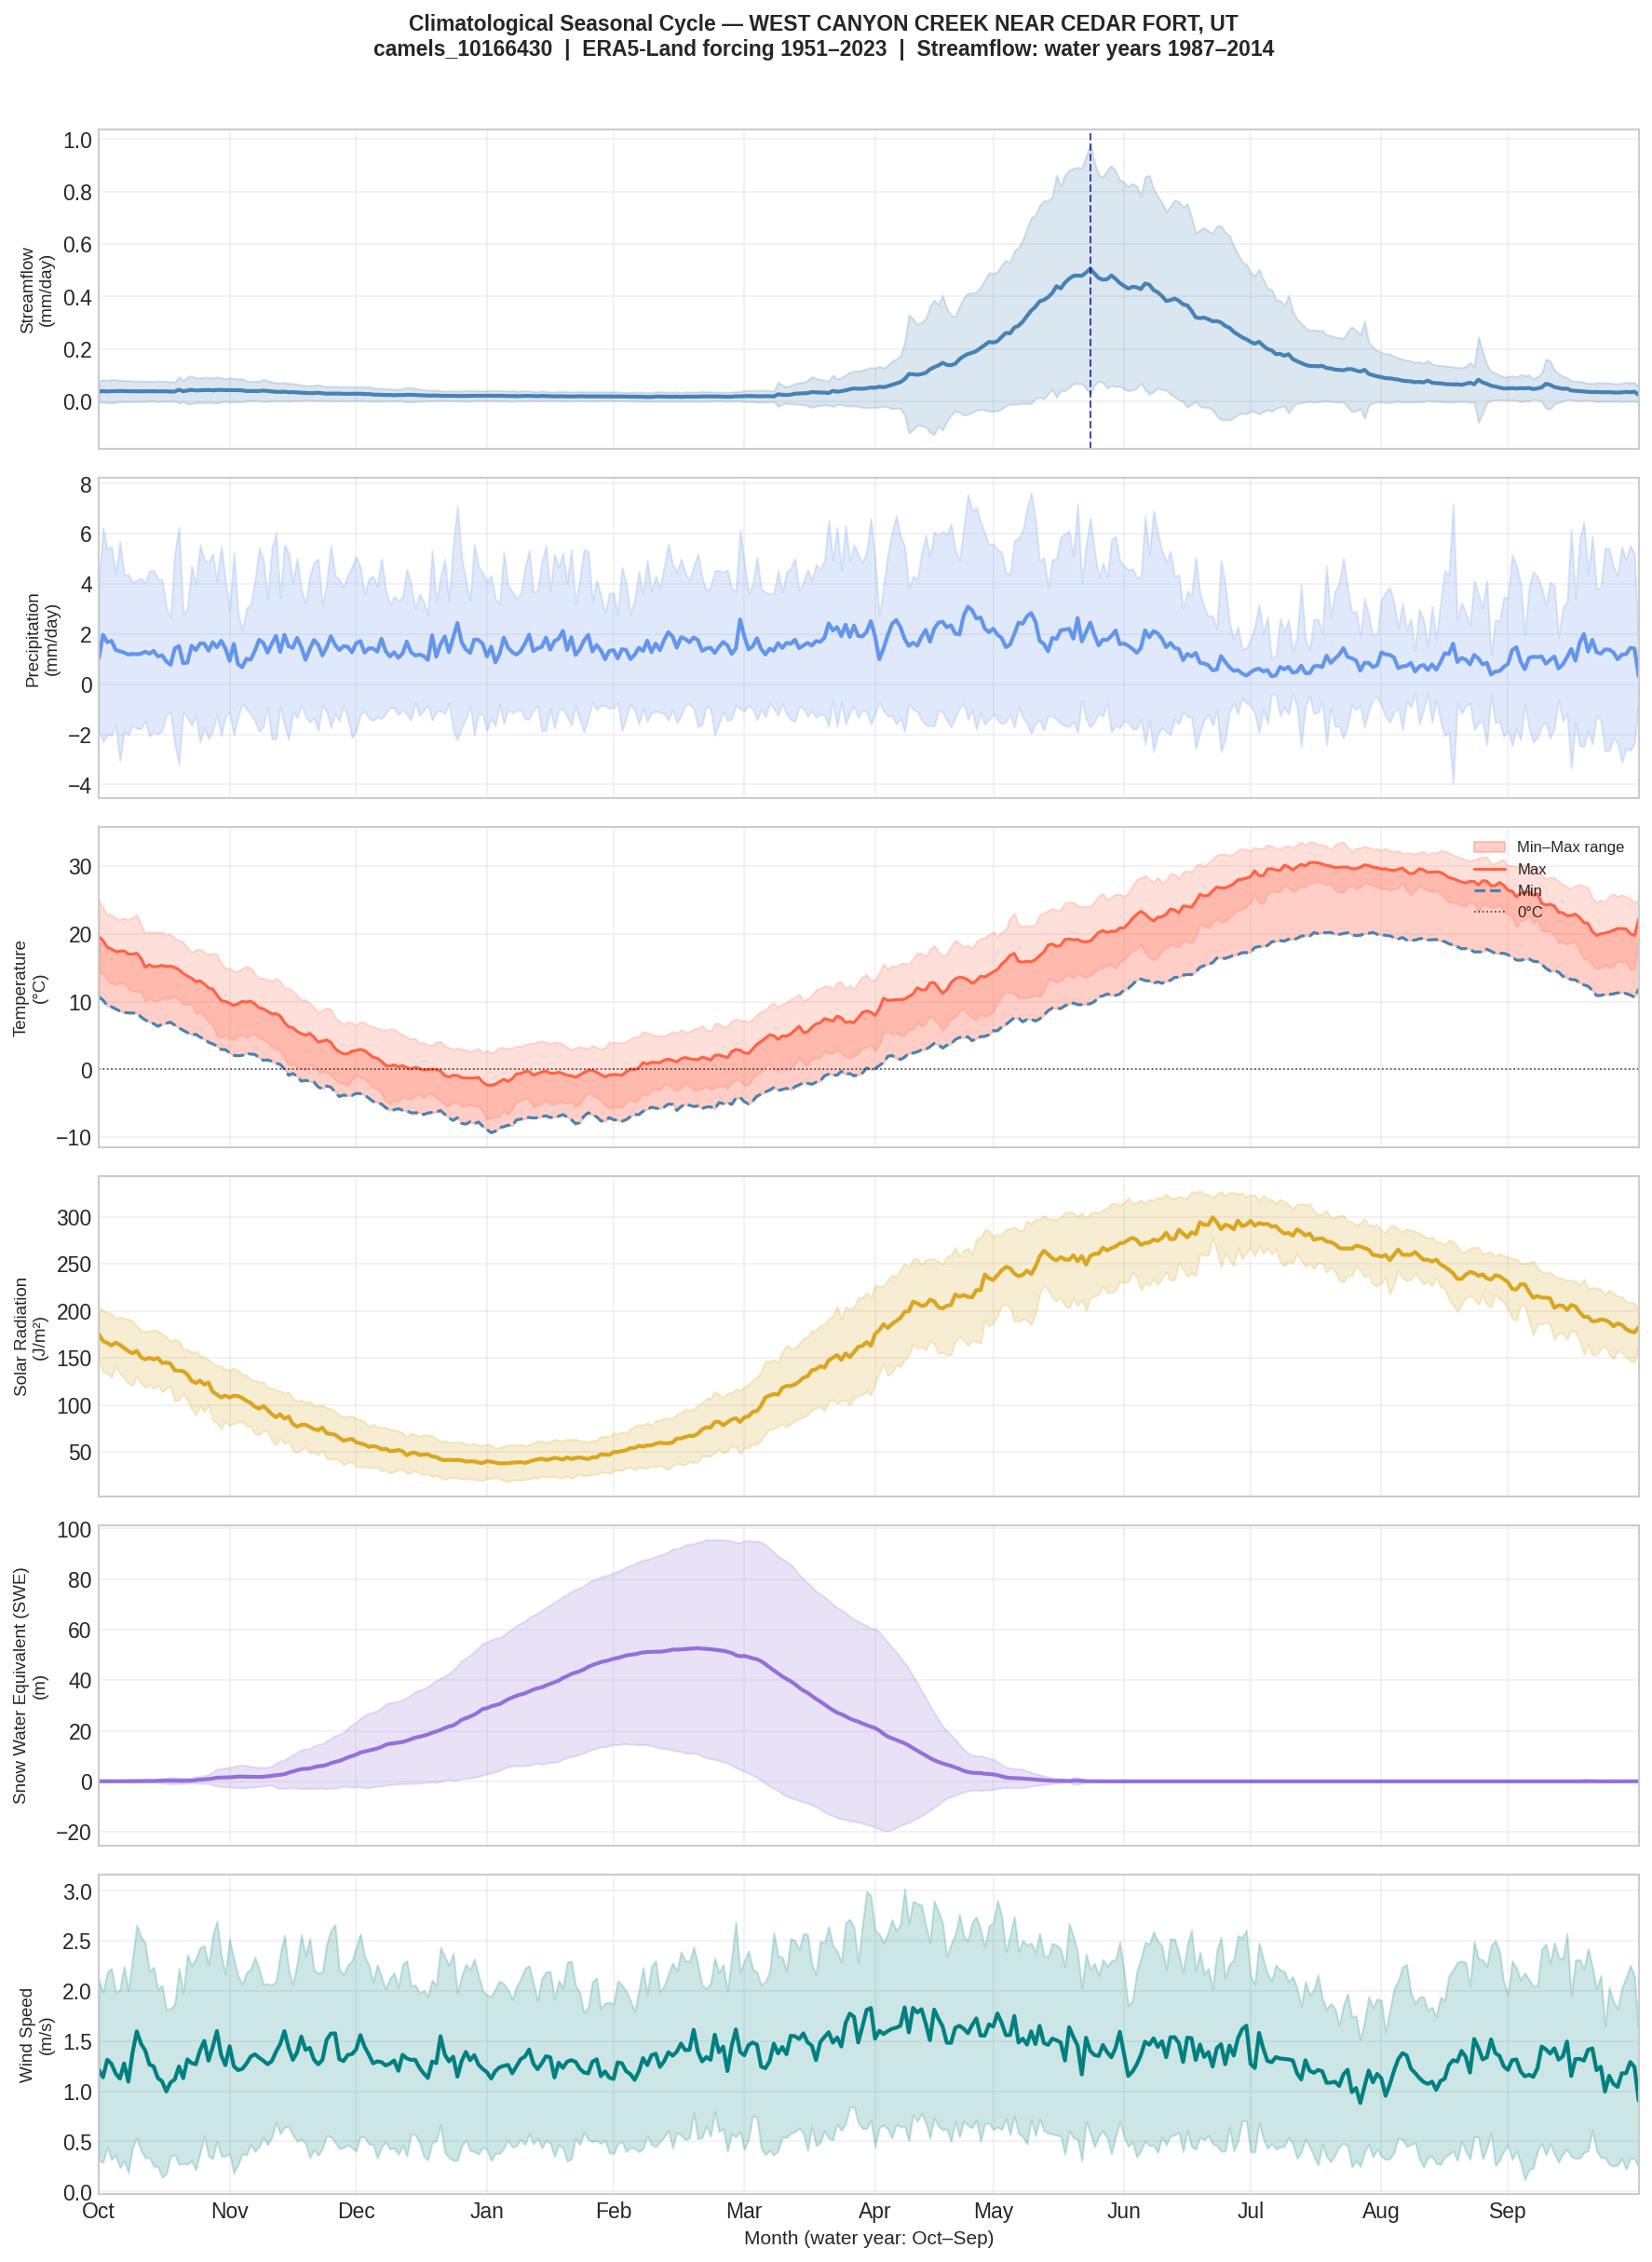

✓ Saved: results/utah_basin_seasonal_cycle.png


In [8]:
# ── Compute wind speed from components ────────────────────────────────────────
df['wind_speed'] = np.sqrt(
    df['u_component_of_wind_10m_mean']**2 +
    df['v_component_of_wind_10m_mean']**2
)

# ── Restrict streamflow climatology to good years only ────────────────────────
df_good_sf = df[df['water_year'].isin(good_years)].copy()

# ── Climatological means by day of water year ─────────────────────────────────
clim_all  = df.groupby('doy_water').mean(numeric_only=True)        # forcing: full record
clim_sf   = df_good_sf.groupby('doy_water').mean(numeric_only=True) # streamflow: good years only

# Day-of-water-year x-axis labels (Oct 1 = day 0)
xticks      = [0, 31, 61, 92, 122, 153, 184, 212, 243, 273, 304, 334]
xlabels     = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']

# ── Variables to plot ──────────────────────────────────────────────────────────
panels = [
    ('streamflow',                      'Streamflow',         'mm/day',  'steelblue',  clim_sf),
    ('total_precipitation_sum',         'Precipitation',      'mm/day',  'cornflowerblue', clim_all),
    ('temperature_2m_max',              'Temperature',        '°C',      'tomato',     clim_all),
    ('surface_net_solar_radiation_mean','Solar Radiation',    'J/m²',    'goldenrod',  clim_all),
    ('snow_depth_water_equivalent_mean','Snow Water Equivalent (SWE)',   'm',       'mediumpurple', clim_all),
    ('wind_speed',                      'Wind Speed',         'm/s',     'teal',       clim_all),
]

# ── Plot ───────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(len(panels), 1, figsize=(12, 16), sharex=True)
fig.suptitle(
    f'Climatological Seasonal Cycle — {closest["gauge_name"]}\n'
    f'{UTAH_BASIN_ID}  |  ERA5-Land forcing 1951–2023  |  '
    f'Streamflow: water years 1987–2014',
    fontsize=11, fontweight='bold', y=1.01
)

for ax, (var, label, unit, color, clim_src) in zip(axes, panels):
    y = clim_src[var]

    # ── Shaded interannual spread ──────────────────────────────────────────────
    if var == 'streamflow':
        std = df_good_sf.groupby('doy_water')[var].std()
    elif var == 'wind_speed':
        std = df.groupby('doy_water')['wind_speed'].std()
    else:
        std = df.groupby('doy_water')[var].std()

    ax.fill_between(y.index, y - std, y + std, alpha=0.2, color=color)

    # ── Temperature: plot min and max as a band ────────────────────────────────
    if var == 'temperature_2m_max':
        t_min = clim_all['temperature_2m_min']
        ax.fill_between(y.index, t_min, y, alpha=0.3, color=color, label='Min–Max range')
        ax.plot(y.index, y, color=color, linewidth=1.5, label='Max')
        ax.plot(t_min.index, t_min, color='steelblue', linewidth=1.5,
                linestyle='--', label='Min')
        ax.axhline(0, color='black', linewidth=0.8, linestyle=':', alpha=0.7,
                   label='0°C')
        ax.legend(fontsize=8, loc='upper right')
    else:
        ax.plot(y.index, y, color=color, linewidth=2)

    ax.set_ylabel(f'{label}\n({unit})', fontsize=9)
    ax.set_xlim(0, 365)
    ax.grid(True, alpha=0.3)

    # ── Annotate spring melt for streamflow ───────────────────────────────────
    if var == 'streamflow':
        peak_doy = y.idxmax()
        ax.axvline(peak_doy, color='darkblue', linewidth=1.0,
                   linestyle='--', alpha=0.7)

axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels(xlabels)
axes[-1].set_xlabel('Month (water year: Oct–Sep)', fontsize=10)

plt.tight_layout()
plt.savefig(PROJECT_DIR / 'results' / 'utah_basin_seasonal_cycle.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: results/utah_basin_seasonal_cycle.png")

## 7. Full Period of Record

The climatological seasonal cycle in the previous plot shows the average behavior,
but it hides interannual variability — wet years vs. dry years, early vs. late
snowmelt, drought periods, and long-term trends.

Here we plot the full period of record for each variable as a continuous timeseries,
with the good streamflow years (1987–2014) highlighted. This gives a sense of:

- **Streamflow intermittency** — how sparse the gauge record is outside 1987–2014
- **Interannual variability** — how much year-to-year variability exists in
  precipitation, temperature, and snow depth
- **Long-term trends** — whether temperature or precipitation show any directional
  change over the ERA5-Land record (1951–2023)

We will plot a subset of the most informative variables to keep the figure readable:
streamflow, precipitation, temperature, and snow depth.

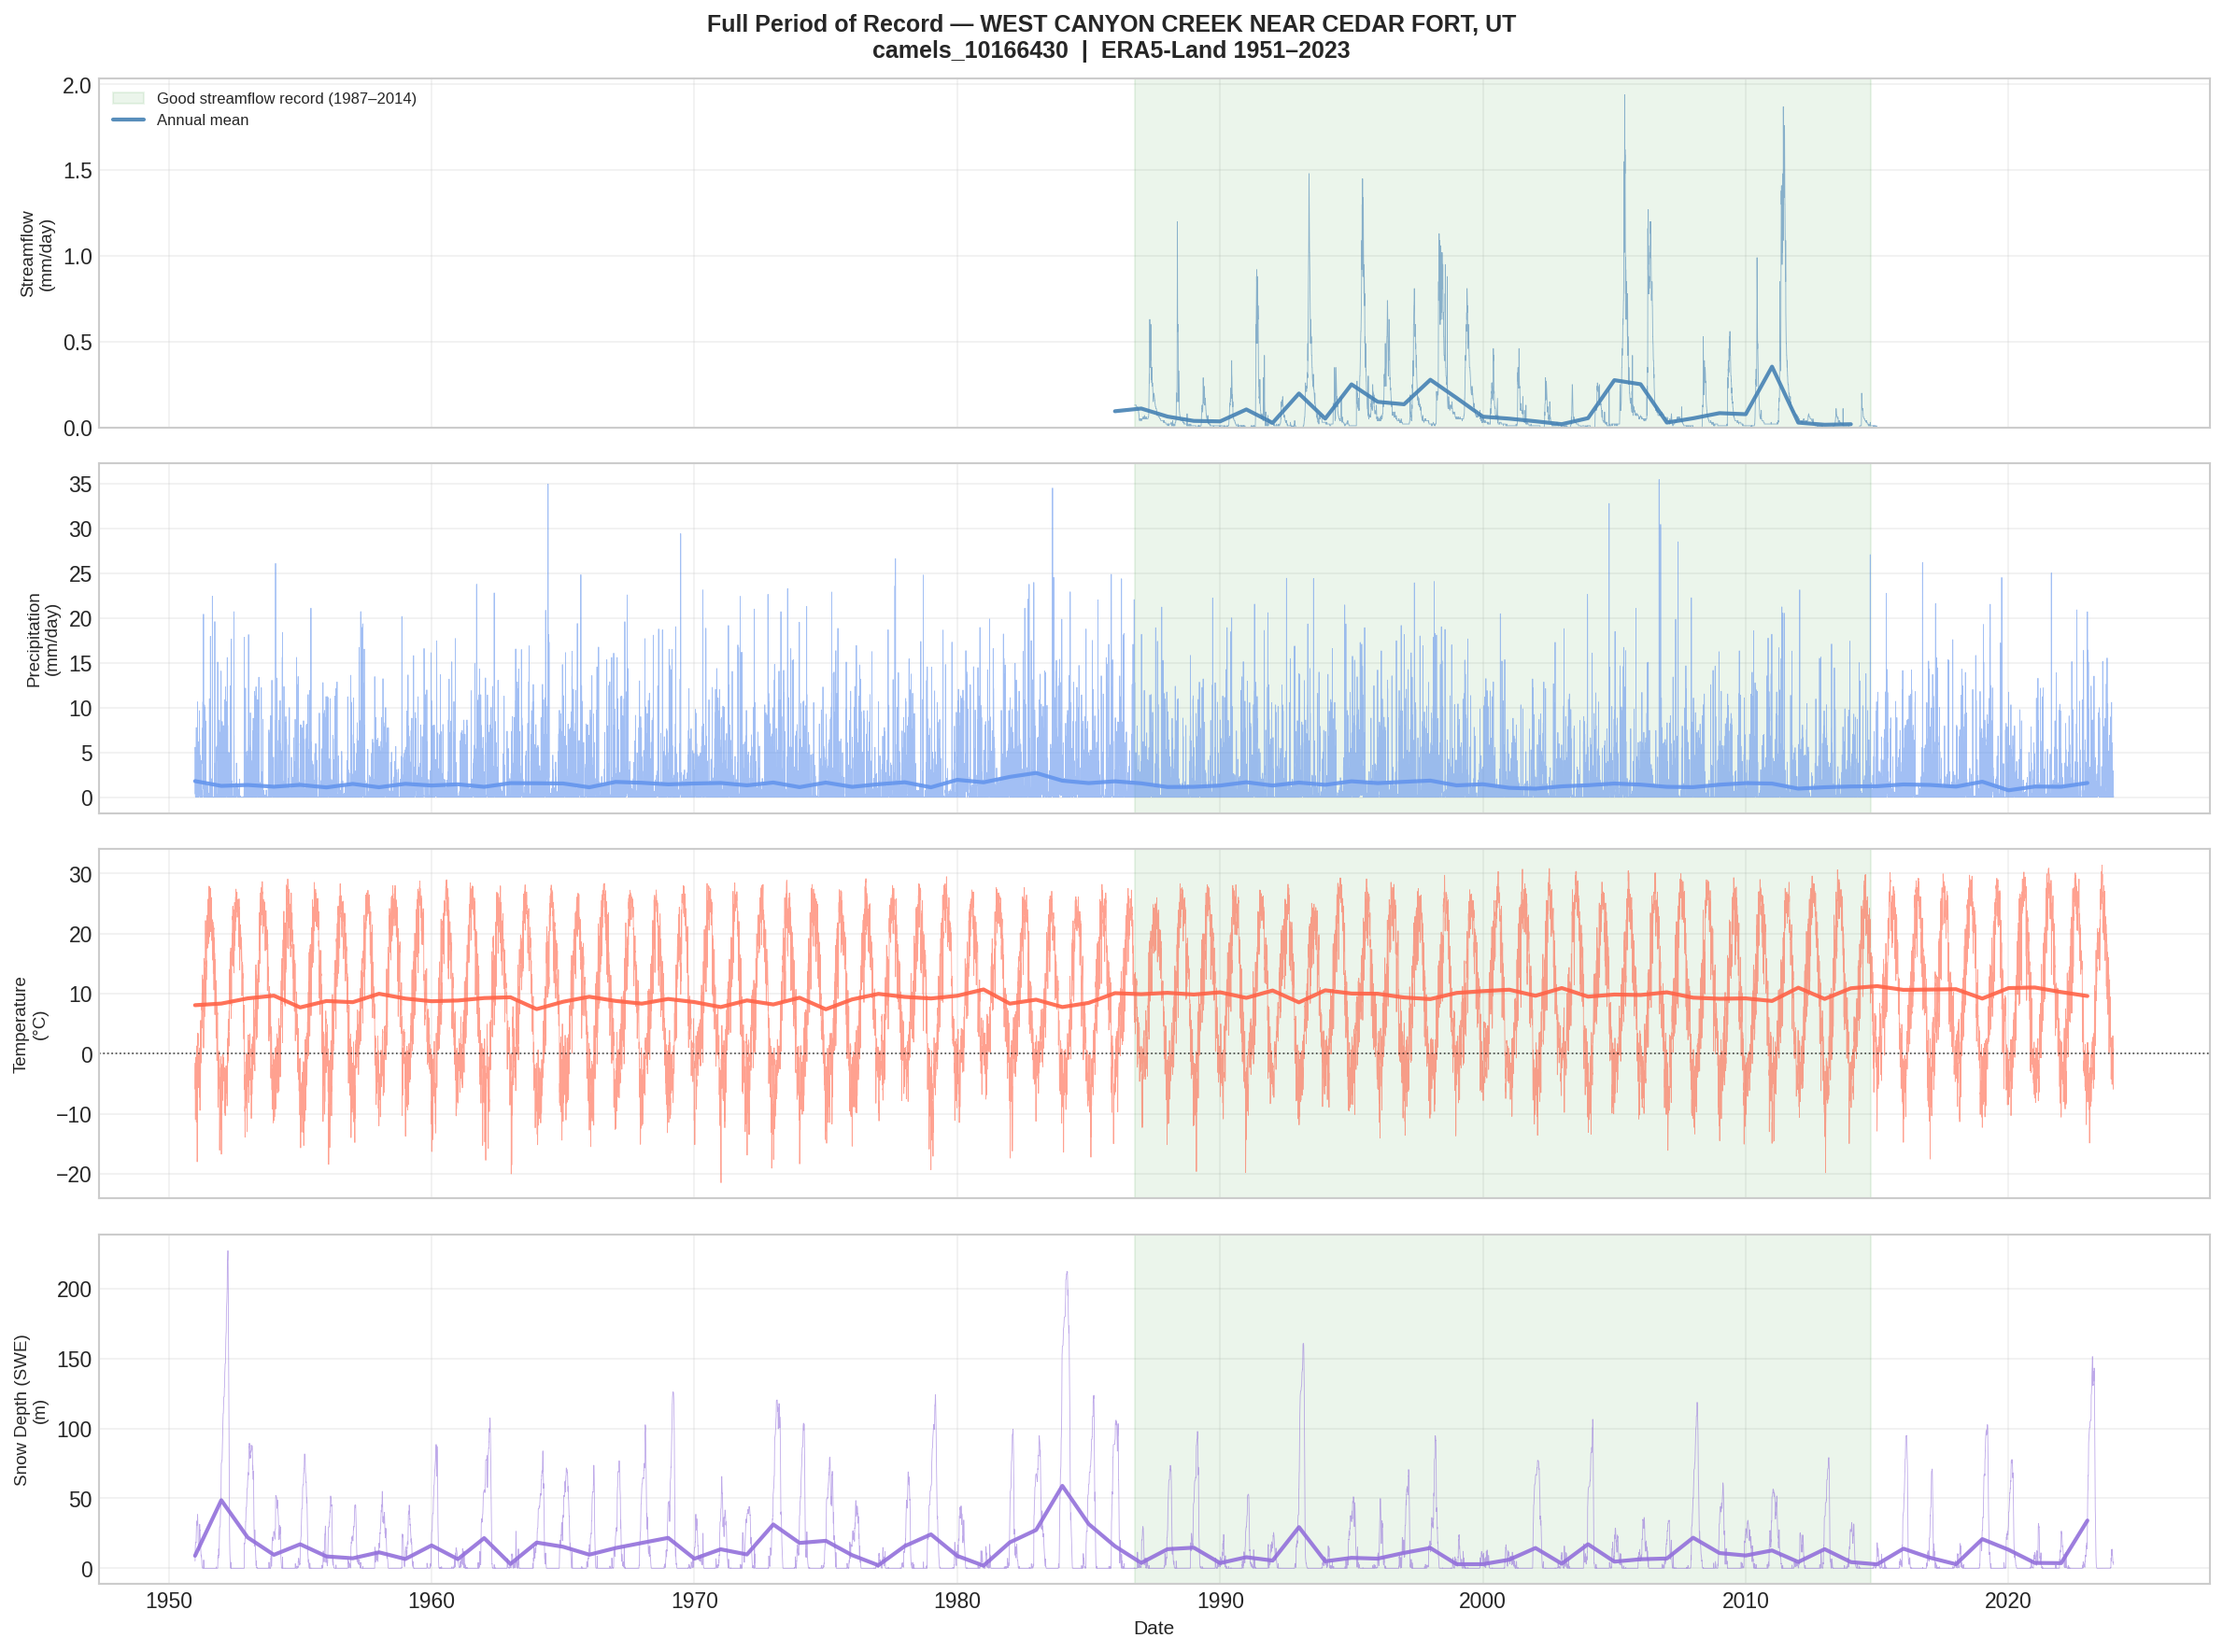

✓ Saved: results/utah_basin_full_record.png


In [9]:
# ── Variables to plot ──────────────────────────────────────────────────────────
record_panels = [
    ('streamflow',                       'Streamflow',       'mm/day',  'steelblue'),
    ('total_precipitation_sum',          'Precipitation',    'mm/day',  'cornflowerblue'),
    ('temperature_2m_mean',              'Temperature',      '°C',      'tomato'),
    ('snow_depth_water_equivalent_mean', 'Snow Depth (SWE)', 'm',       'mediumpurple'),
]

fig, axes = plt.subplots(len(record_panels), 1, figsize=(16, 12), sharex=True)
fig.suptitle(
    f'Full Period of Record — {closest["gauge_name"]}\n'
    f'{UTAH_BASIN_ID}  |  ERA5-Land 1951–2023',
    fontsize=12, fontweight='bold'
)

# ── Highlight good streamflow years ───────────────────────────────────────────
good_start = pd.Timestamp(f'{good_years[0]-1}-10-01')
good_end   = pd.Timestamp(f'{good_years[-1]}-09-30')

for ax, (var, label, unit, color) in zip(axes, record_panels):
    # ── Shade good streamflow period ──────────────────────────────────────────
    ax.axvspan(good_start, good_end, alpha=0.08, color='green',
               label='Good streamflow record (1987–2014)')

    # ── Plot raw daily data as thin line ──────────────────────────────────────
    ax.plot(df.index, df[var], color=color, linewidth=0.4, alpha=0.6)

    # ── Overlay annual mean as thicker line ───────────────────────────────────
    annual_mean = df[var].resample('YS').mean()
    ax.plot(annual_mean.index, annual_mean, color=color,
            linewidth=2.0, alpha=0.9, label='Annual mean')

    # ── Zero line for temperature ──────────────────────────────────────────────
    if var == 'temperature_2m_mean':
        ax.axhline(0, color='black', linewidth=0.8, linestyle=':', alpha=0.7)

    ax.set_ylabel(f'{label}\n({unit})', fontsize=9)
    ax.grid(True, alpha=0.3)

    # ── Legend on first panel only ────────────────────────────────────────────
    if var == 'streamflow':
        ax.legend(fontsize=8, loc='upper left')
        ax.set_ylim(bottom=0)

axes[-1].set_xlabel('Date', fontsize=10)

plt.tight_layout()
plt.savefig(PROJECT_DIR / 'results' / 'utah_basin_full_record.png',
            dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: results/utah_basin_full_record.png")

## Appendix: neuralhydrology Framework Primer

Before moving to `02_neural_hydrology_caravan_setup.ipynb`, it is helpful to understand
how neuralhydrology loads and interprets the CARAVAN data we just explored. This section
gives a brief look at the framework's internal structure.

### How neuralhydrology reads CARAVAN
When you pass `dataset: caravan` and a `data_dir` in the config, neuralhydrology:
1. Reads the basin list from `train_basin_file`
2. For each basin ID (e.g. `camels_01013500`), extracts the region prefix (`camels`)
3. Loads the timeseries from `data_dir/timeseries/csv/{region}/{basin_id}.csv`
4. Loads static attributes from `data_dir/attributes/{region}/attributes_*.csv`
5. Constructs input sequences of length `seq_length` days for the LSTM

### The Config object
Every neuralhydrology experiment is fully described by a `Config` object loaded from
the `.yml` file. All valid config keys are properties of the `Config` class — if a key
is not a property, neuralhydrology will throw an error at startup.

### The get_dataset function
`get_dataset()` is the entry point for data loading. It reads the config and returns
a PyTorch `Dataset` object that the `DataLoader` iterates over during training.
Understanding its signature helps clarify what the config keys actually control.

### Why this matters for Alaska transfer learning
The same `get_dataset` machinery will be used when we deploy the trained model on
Alaska basins — we just swap in Alaska-specific timeseries and attributes files
organized in the same directory structure. Understanding the framework internals
now makes that step much easier.

In [10]:
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.utils.config import Config
import inspect

# ── get_dataset signature ──────────────────────────────────────────────────────
print("get_dataset signature:")
print("=" * 60)
print(inspect.signature(get_dataset))
print()
sig = inspect.signature(get_dataset)
for name, param in sig.parameters.items():
    print(f"  {name:<20s} default: {param.default}")

# ── All valid Config keys ──────────────────────────────────────────────────────
print("\n" + "=" * 60)
print("All valid neuralhydrology config keys:")
print("=" * 60)
property_names = sorted([
    p for p in dir(Config)
    if isinstance(getattr(Config, p), property)
])
for i, key in enumerate(property_names, 1):
    print(f"  {i:3d}. {key}")

# ── Basin-related keys ─────────────────────────────────────────────────────────
print("\n" + "=" * 60)
print("Basin-related config keys:")
print("=" * 60)
basin_keys = [k for k in property_names if 'basin' in k.lower()]
for key in basin_keys:
    print(f"  {key}")

# ── Keys used in our config ────────────────────────────────────────────────────
print("\n" + "=" * 60)
print("Keys used in our caravan_snow_scenario1.yml:")
print("=" * 60)
our_keys = [
    'experiment_name', 'run_dir',
    'train_basin_file', 'validation_basin_file', 'test_basin_file',
    'train_start_date', 'train_end_date',
    'validation_start_date', 'validation_end_date',
    'test_start_date', 'test_end_date',
    'dataset', 'data_dir',
    'model', 'head', 'output_activation', 'hidden_size',
    'initial_forget_bias', 'output_dropout',
    'dynamic_inputs', 'target_variables', 'clip_targets_to_zero',
    'optimizer', 'loss', 'epochs', 'learning_rate',
    'batch_size', 'clip_gradient_norm', 'seq_length', 'predict_last_n',
    'validate_every', 'validate_n_random_basins', 'cache_validation_data',
    'metrics', 'device', 'num_workers', 'seed',
    'log_interval', 'log_tensorboard', 'log_n_figures',
    'save_weights_every', 'save_validation_results',
]
for key in our_keys:
    valid = '✓' if key in property_names else '✗  NOT FOUND'
    print(f"  {valid}  {key}")

get_dataset signature:
(cfg: neuralhydrology.utils.config.Config, is_train: bool, period: str, basin: str = None, additional_features: list = [], id_to_int: dict = {}, scaler: dict = {}) -> neuralhydrology.datasetzoo.basedataset.BaseDataset

  cfg                  default: <class 'inspect._empty'>
  is_train             default: <class 'inspect._empty'>
  period               default: <class 'inspect._empty'>
  basin                default: None
  additional_features  default: []
  id_to_int            default: {}
  scaler               default: {}

All valid neuralhydrology config keys:
    1. additional_feature_files
    2. allow_subsequent_nan_losses
    3. autoregressive_inputs
    4. base_run_dir
    5. batch_size
    6. bidirectional_stacked_forecast_lstm
    7. cache_validation_data
    8. checkpoint_path
    9. clip_gradient_norm
   10. clip_targets_to_zero
   11. conceptual_model
   12. continue_from_epoch
   13. custom_normalization
   14. data_dir
   15. dataset
   16. devic